# HW6 Sea-serface temperature whcih uses an LSTM/ decoder
### Author: Qiyue Chen
### Github link: https://github.com/qchen4/EE399A/tree/main/HW6

## Part 1: sea-surface temperature model

### Data Import

Data/               example.ipynb       processdata.py
README.md           forecasts.py        pyshred/
__pycache__/        models.py           reconstructions.py


In [15]:
!git clone https://github.com/Jan-Williams/pyshred/

Cloning into 'pyshred'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 12), reused 16 (delta 5), pack-reused 0
Receiving objects: 100% (28/28), 10.93 KiB | 5.47 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [13]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.4 MB/s eta 0:00:00m eta 0:00:010:01


### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [18]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3
lags = 52
load_X = load_data("SST")
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

ValueError: Unknown mat file type, version 49, 56

We now select indices to divide the data into training, validation, and test sets.

In [4]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask != 0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [5]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i : i + lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = "cuda" if torch.cuda.is_available() else "cpu"

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(
    transformed_X[train_indices + lags - 1], dtype=torch.float32
).to(device)
valid_data_out = torch.tensor(
    transformed_X[valid_indices + lags - 1], dtype=torch.float32
).to(device)
test_data_out = torch.tensor(
    transformed_X[test_indices + lags - 1], dtype=torch.float32
).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [6]:
shred = models.SHRED(
    num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1
).to(device)
validation_errors = models.fit(
    shred,
    train_dataset,
    valid_dataset,
    batch_size=64,
    num_epochs=1000,
    lr=1e-3,
    verbose=True,
    patience=5,
)

Training epoch 1
Error tensor(0.4745, device='cuda:0')
Training epoch 20
Error tensor(0.2255, device='cuda:0')
Training epoch 40
Error tensor(0.2077, device='cuda:0')
Training epoch 60
Error tensor(0.2020, device='cuda:0')
Training epoch 80
Error tensor(0.2048, device='cuda:0')
Training epoch 100
Error tensor(0.2011, device='cuda:0')
Training epoch 120
Error tensor(0.1967, device='cuda:0')
Training epoch 140
Error tensor(0.1901, device='cuda:0')
Training epoch 160
Error tensor(0.1840, device='cuda:0')
Training epoch 180
Error tensor(0.1745, device='cuda:0')
Training epoch 200
Error tensor(0.1694, device='cuda:0')
Training epoch 220
Error tensor(0.1599, device='cuda:0')
Training epoch 240
Error tensor(0.1520, device='cuda:0')
Training epoch 260
Error tensor(0.1451, device='cuda:0')
Training epoch 280
Error tensor(0.1377, device='cuda:0')
Training epoch 300
Error tensor(0.1316, device='cuda:0')
Training epoch 320
Error tensor(0.1280, device='cuda:0')
Training epoch 340
Error tensor(0.124

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(
    np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
)

0.019539071


## Part 2: Plotting the results

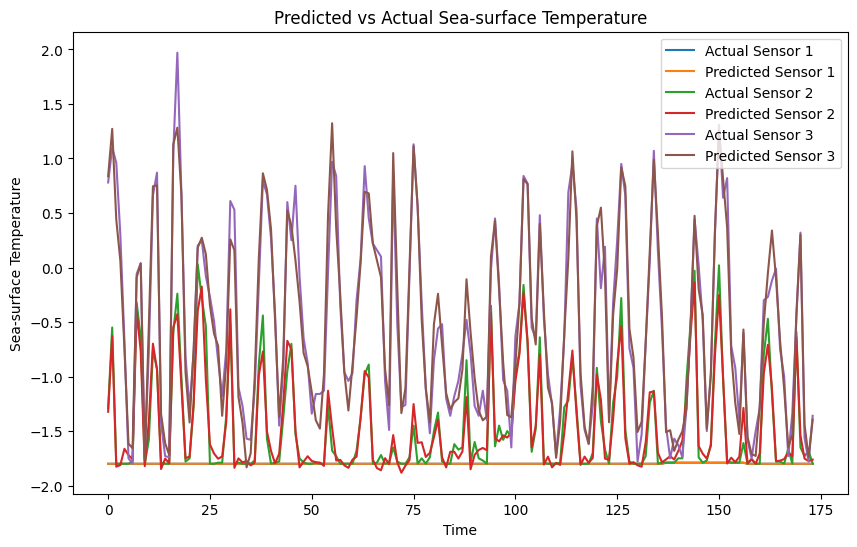

In [10]:
# Generate predictions on the test dataset if the model was trained successfully
if "shred" in locals():
    with torch.no_grad():
        shred.eval()
        test_predictions = shred(test_dataset[:][0])

    # Inverse transform the predictions and actual values
    test_predictions = sc.inverse_transform(test_predictions.cpu().numpy())
    test_actual = sc.inverse_transform(test_dataset[:][1].cpu())

    # Plot the predicted and actual values for each sensor location
    num_sensor_locations = len(sensor_locations)
    plt.figure(figsize=(10, 6))
    for i in range(num_sensor_locations):
        plt.plot(test_actual[:, sensor_locations[i]], label=f"Actual Sensor {i+1}")
        plt.plot(
            test_predictions[:, sensor_locations[i]], label=f"Predicted Sensor {i+1}"
        )
    plt.xlabel("Time")
    plt.ylabel("Sea-surface Temperature")
    plt.title("Predicted vs Actual Sea-surface Temperature")
    plt.legend()
    plt.show()
else:
    print("The SHRED model is not available.")

## Part 3: Function of time lag variable

Training epoch 1
Error tensor(0.4850, device='cuda:0')
Training epoch 1
Error tensor(0.4723, device='cuda:0')
Training epoch 1
Error tensor(0.4801, device='cuda:0')
Training epoch 1
Error tensor(0.5007, device='cuda:0')
Training epoch 1
Error tensor(0.4754, device='cuda:0')
Training epoch 1
Error tensor(0.4833, device='cuda:0')


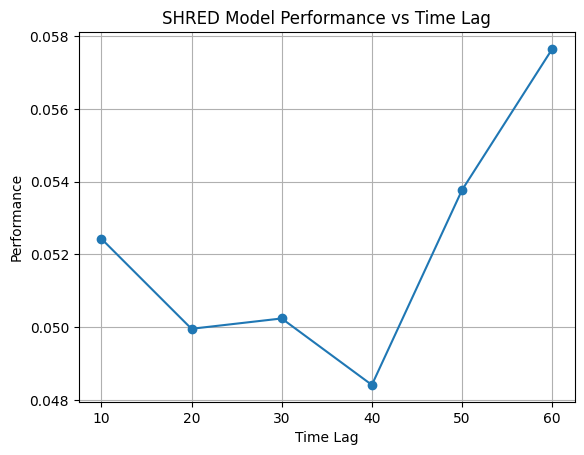

In [26]:
# Define a list of time lag values to test
lag_values = np.arange(10, 70, 10)

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each lag value
for lag in lag_values:
    num_sensors = 3

    # Load the data
    load_X = load_data("SST")

    # Apply the time lag to the loaded data
    load_X = load_X[lag:]

    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i : i + lag, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(
        device
    )
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(
        device
    )
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(
        device
    )

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(
        transformed_X[train_indices + lag - 1], dtype=torch.float32
    ).to(device)
    valid_data_out = torch.tensor(
        transformed_X[valid_indices + lag - 1], dtype=torch.float32
    ).to(device)
    test_data_out = torch.tensor(
        transformed_X[test_indices + lag - 1], dtype=torch.float32
    ).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(
        num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1
    ).to(device)
    validation_errors = models.fit(
        shred,
        train_dataset,
        valid_dataset,
        batch_size=64,
        num_epochs=10,
        lr=1e-3,
        verbose=True,
        patience=5,
    )
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(
        test_ground_truth
    )
    performance_results.append(performance)

# Plot the performance results
plt.plot(lag_values, performance_results, marker="o")
plt.xlabel("Time Lag")
plt.ylabel("Performance")
plt.title("SHRED Model Performance vs Time Lag")
plt.grid(True)
plt.show()

## Part 4: Function of Noise

Training epoch 1
Error tensor(0.4603, device='cuda:0')
Training epoch 1
Error tensor(0.4467, device='cuda:0')
Training epoch 1
Error tensor(0.4542, device='cuda:0')
Training epoch 1
Error tensor(0.4416, device='cuda:0')
Training epoch 1
Error tensor(0.4434, device='cuda:0')
Training epoch 1
Error tensor(0.4182, device='cuda:0')
Training epoch 1
Error tensor(0.4450, device='cuda:0')
Training epoch 1
Error tensor(0.4316, device='cuda:0')
Training epoch 1
Error tensor(0.4094, device='cuda:0')
Training epoch 1
Error tensor(0.4208, device='cuda:0')
Training epoch 1
Error tensor(0.4263, device='cuda:0')
Training epoch 1
Error tensor(0.3963, device='cuda:0')
Training epoch 1
Error tensor(0.4009, device='cuda:0')
Training epoch 1
Error tensor(0.4301, device='cuda:0')
Training epoch 1
Error tensor(0.4155, device='cuda:0')
Training epoch 1
Error tensor(0.4425, device='cuda:0')
Training epoch 1
Error tensor(0.3807, device='cuda:0')
Training epoch 1
Error tensor(0.3863, device='cuda:0')
Training e

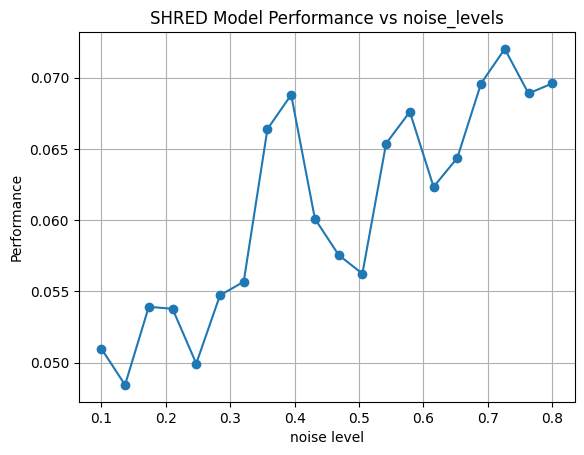

In [22]:
# Define a list of noise levels to test
noise_levels = np.linspace(0.1, 0.8, 20)

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each noise level
for noise_level in noise_levels:
    num_sensors = 3
    lag = 52

    # Load the data
    load_X = load_data("SST")

    # Add negative Gaussian noise to the data
    noisy_X = load_X - np.random.normal(loc=0, scale=noise_level, size=load_X.shape)

    n = noisy_X.shape[0]
    m = noisy_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(noisy_X[train_indices])
    transformed_X = sc.transform(noisy_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i : i + lag, sensor_locations]

    # Generate training, validation, and test datasets
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(
        device
    )
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(
        device
    )
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(
        device
    )
    train_data_out = torch.tensor(
        transformed_X[train_indices + lag - 1], dtype=torch.float32
    ).to(device)
    valid_data_out = torch.tensor(
        transformed_X[valid_indices + lag - 1], dtype=torch.float32
    ).to(device)
    test_data_out = torch.tensor(
        transformed_X[test_indices + lag - 1], dtype=torch.float32
    ).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the SHRED model
    shred = models.SHRED(
        num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1
    ).to(device)
    validation_errors = models.fit(
        shred,
        train_dataset,
        valid_dataset,
        batch_size=64,
        num_epochs=10,
        lr=1e-3,
        verbose=True,
        patience=5,
    )

    # Evaluate the model's performance on the test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(
        test_ground_truth
    )
    performance_results.append(performance)

# Plot the performance results
plt.plot(noise_levels, performance_results, marker="o")
plt.xlabel("noise level")
plt.ylabel("Performance")
plt.title("SHRED Model Performance vs noise_levels")
plt.grid(True)
plt.show()

## Part 5: Function of number of sensors

Training epoch 1
Error tensor(0.4842, device='cuda:0')
Training epoch 1
Error tensor(0.4854, device='cuda:0')
Training epoch 1
Error tensor(0.4736, device='cuda:0')
Training epoch 1
Error tensor(0.4762, device='cuda:0')
Training epoch 1
Error tensor(0.4699, device='cuda:0')
Training epoch 1
Error tensor(0.4788, device='cuda:0')
Training epoch 1
Error tensor(0.4691, device='cuda:0')
Training epoch 1
Error tensor(0.4801, device='cuda:0')
Training epoch 1
Error tensor(0.4623, device='cuda:0')
Training epoch 1
Error tensor(0.4745, device='cuda:0')
Training epoch 1
Error tensor(0.4702, device='cuda:0')
Training epoch 1
Error tensor(0.4838, device='cuda:0')
Training epoch 1
Error tensor(0.4621, device='cuda:0')
Training epoch 1
Error tensor(0.4792, device='cuda:0')
Training epoch 1
Error tensor(0.4642, device='cuda:0')
Training epoch 1
Error tensor(0.4695, device='cuda:0')
Training epoch 1
Error tensor(0.4640, device='cuda:0')
Training epoch 1
Error tensor(0.4799, device='cuda:0')
Training e

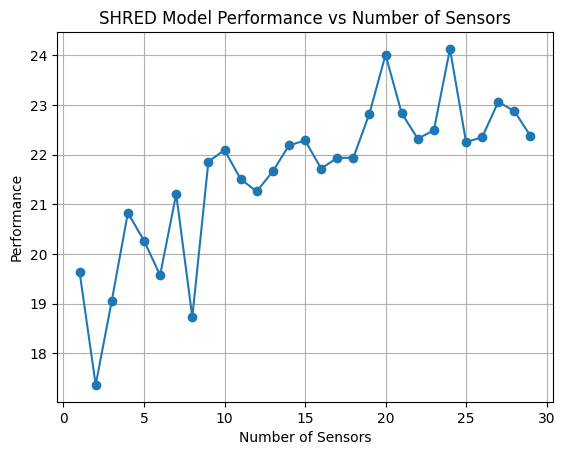

In [19]:
# Define a list of sensor counts to test
sensor_counts = np.arange(1, 30)

# Initialize an empty list to store the performance results
performance_results = []

# Iterate over each sensor count
for num_sensors in sensor_counts:
    lag = 52

    # Load the data
    load_X = load_data("SST")

    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lag, size=1000, replace=False)
    mask = np.ones(n - lag)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lag)[np.where(mask != 0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i : i + lag, sensor_locations]

    # Generate training, validation, and test datasets
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(
        device
    )
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(
        device
    )
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(
        device
    )
    train_data_out = torch.tensor(
        transformed_X[train_indices + lag - 1], dtype=torch.float32
    ).to(device)
    valid_data_out = torch.tensor(
        transformed_X[valid_indices + lag - 1], dtype=torch.float32
    ).to(device)
    test_data_out = torch.tensor(
        transformed_X[test_indices + lag - 1], dtype=torch.float32
    ).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Train the SHRED model
    shred = models.SHRED(
        num_sensors, m, hidden_size=64, hidden_layers=1, l1=350, l2=400, dropout=0.1
    ).to(device)
    validation_errors = models.fit(
        shred,
        train_dataset,
        valid_dataset,
        batch_size=64,
        num_epochs=10,
        lr=1e-3,
        verbose=True,
        patience=5,
    )

    # Evaluate the model's performance on the test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(
        test_ground_truth
    )
    performance = 1 / error  # Calculate performance as the inverse of the error
    performance_results.append(performance)

# Plot the performance results
plt.plot(sensor_counts, performance_results, marker="o")
plt.xlabel("Number of sensors")
plt.ylabel("Performance")
plt.title("SHRED Model Performance vs Number of Sensors")
plt.grid(True)
plt.show()